# 前処理案
- 正規化
- フレーミング
- ローパスフィルター
- 窓関数

# 事前学習
- 画像データと脳波データを用いてCLIPを使った事前学習を行う
  - 画像部分は事前学習済みモデルを使う
- [第8回「産業基盤の創生」研究成果報告会](https://jp.foundation.canon/common/pdf/aid_awardees/9/14_yanagisawa_cfk9.pdf)
- モデルはVisionTransformer
- encoder部分を実際に使う

脳波の前処理
- 配布したデータに対しては前処理が加えられていません．リサンプリングやフィルタリング，スケーリング，ベースライン補正など，波に対する基本的な前処理を試すことで性能の向上が見こまれます．


画像データを用いた事前学習
- 本コンペのタスクは脳波のクラス分類ですが，配布してある画像データを脳波エンコーダの事前学習に用いることを許可します．
- 例）CLIP [Radford+ 2021]

音声モデルの導入
- 脳波と同じ波である音声を扱うアーキテクチャを用いることが有効であると知られています．

過学習を防ぐ正則化やドロップアウト

被験者情報の利用
- 被験者ごとに脳波の特性が異なる可能性があるため，被験者情報を利用することで性能向上が見込まれます．
- 例）Subject-specific layer [Defossez+ 2022], domain adaptation

In [4]:
import torch
import os
from pathlib import Path


data_dir = Path("/data/daichi/MEG/data")
split = "train"
X = torch.load(os.path.join(data_dir, f"{split}_X.pt"))
y = torch.load(os.path.join(data_dir, f"{split}_y.pt"))

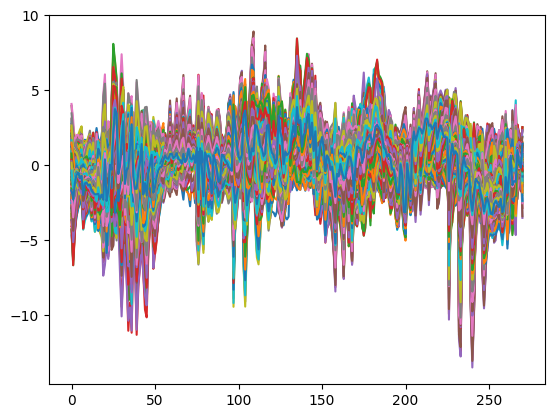

tensor(1759)


In [16]:
# 波の可視化
import matplotlib.pyplot as plt

plt.plot(X[0].numpy())
plt.show()
print(y[0])

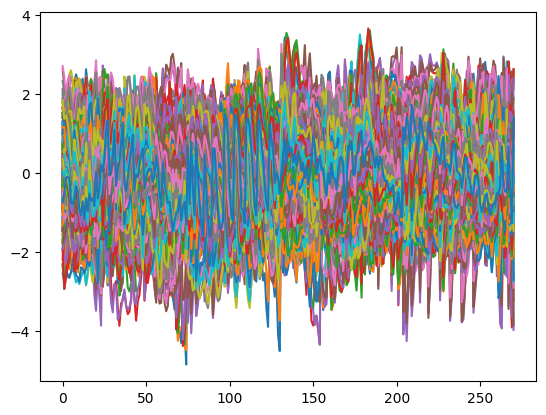

In [15]:
X_mean = X[0].mean(dim=1)  # Average over channels
X_std = X[0].std(dim=1)  # Average over channels
X_trans = (X[0] - X_mean[:, None]) / X_std[:, None]
plt.plot(X_trans.numpy())
plt.show()

In [5]:
X.shape[1] * X.shape[2]

76151

In [6]:
print(X.shape[1], X.shape[2])

271 281


In [8]:
y.shape

torch.Size([65728])

In [1]:
10 ** 0.5 / 2

1.5811388300841898

In [4]:
10 / 3 * 5 ** 0.5

7.4535599249993

In [1]:
a = "ribbon_13s.jpg"
a.split("/")

['ribbon_13s.jpg']

In [6]:
import os
image_paths = "ribbon_13s.jpg"
image_data_dir = "/data/daichi/MEG"
back_split_dirs = image_paths.split("/")
print(back_split_dirs)
if len(back_split_dirs) == 1:
    split_dirs = image_paths.split("_")
    if len(split_dirs) == 2:
        image_path = os.path.join(
            image_data_dir, split_dirs[0], image_paths)
    elif len(split_dirs) == 1:
        image_path = os.path.join(image_data_dir, image_paths)
    elif len(split_dirs) == 3:
        image_path = os.path.join(
            image_data_dir, "_".join(split_dirs[0], split_dirs[1]), image_paths)
else:
    image_path = os.path.join(image_data_dir, image_paths)

print(image_path)

['ribbon_13s.jpg']
/data/daichi/MEG/ribbon/ribbon_13s.jpg


In [7]:
# Sourced directly from OpenAI's CLIP repo
from collections import OrderedDict
from typing import Tuple, Union

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes *
                 self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(
            spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2]
                      * x.shape[3]).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x, key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat(
                [self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )

        return x[0]


class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3,
                               stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.conv2 = nn.Conv2d(width // 2, width // 2,
                               kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.conv3 = nn.Conv2d(
            width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.avgpool = nn.AvgPool2d(2)
        self.relu = nn.ReLU(inplace=True)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(
            input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            for conv, bn in [(self.conv1, self.bn1), (self.conv2, self.bn2), (self.conv3, self.bn3)]:
                x = self.relu(bn(conv(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(
            dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(
            *[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])
        self.input_projection = nn.Linear(width, width)

    def forward(self, x: torch.Tensor):
        x = self.input_projection(x) # 埋め込み次元に変換、transformerの内部次元に合わせる
        return self.resblocks(x)


class VisualTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width,
                               kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(
            scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        # shape = [*, width, grid ** 2]
        x = x.reshape(x.shape[0], x.shape[1], -1)
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1],
                      dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x


class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # brainwave
                 context_length: int,
                #  vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int,
                 input_dim: int = 271*281
                 ):
        super().__init__()

        self.context_length = context_length

        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisualTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask() #transformer_layers * transformer_width
        )

        self.brainwave_projection = nn.Linear(input_dim, transformer_width)  # 脳波データのための線形層,wordembeddingの代わり

        # self.vocab_size = vocab_size
        # self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(
            torch.empty(self.context_length, transformer_width))
        # self.ln_final = LayerNorm(transformer_width)

        # self.text_projection = nn.Parameter(
        #     torch.empty(transformer_width, embed_dim))
        # self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(
            torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        # nn.init.normal_(self.token_embedding.weight, std=0.02)
        # nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * \
            ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection,
                            std=self.transformer.width ** -0.5)

    # def build_attention_mask(self):
    #     # lazily create causal attention mask, with full attention between the vision tokens
    #     # pytorch uses additive attention mask; fill with -inf
    #     mask = torch.empty(self.context_length, self.context_length)
    #     mask.fill_(float("-inf"))
    #     mask.triu_(1)  # zero out the lower diagonal
    #     return mask
    def build_attention_mask(self): # , size: int
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask
        # mask = torch.full((size, size), float('-inf'))
        # mask.triu_(1)
        # return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    # def encode_text(self, text):
    #     x = self.token_embedding(text).type(
    #         self.dtype)  # [batch_size, n_ctx, d_model]

    #     x = x + self.positional_embedding.type(self.dtype)
    #     x = x.permute(1, 0, 2)  # NLD -> LND
    #     x = self.transformer(x)
    #     x = x.permute(1, 0, 2)  # LND -> NLD
    #     x = self.ln_final(x).type(self.dtype)

    #     # x.shape = [batch_size, n_ctx, transformer.width]
    #     # take features from the eot embedding (eot_token is the highest number in each sequence)
    #     x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)
    #           ] @ self.text_projection

    #     return x

    def encode_brainwaves(self, brainwaves):
        x = self.brainwave_projection(brainwaves)  # 脳波データを線形変換 (batch_size, 768)
        x = self.transformer(x)
        x = self.ln_final(x)
        return x @ self.text_projection

    def forward(self, image, brainwave):
        image_features = self.encode_image(image)
        brainwave_features = self.encode_brainwaves(brainwave)

        # normalized features
        image_features = image_features / \
            image_features.norm(dim=-1, keepdim=True)
        brainwave_features = brainwave_features / \
            brainwave_features.norm(dim=-1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ brainwave_features.t()
        logits_per_brainwave = logit_scale * brainwave_features @ image_features.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_brainwave


# def convert_weights(model: nn.Module):
#     """Convert applicable model parameters to fp16"""

#     def _convert_weights_to_fp16(l):
#         if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
#             l.weight.data = l.weight.data.half()
#             if l.bias is not None:
#                 l.bias.data = l.bias.data.half()

#         if isinstance(l, nn.MultiheadAttention):
#             for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
#                 tensor = getattr(l, attr)
#                 if tensor is not None:
#                     tensor.data = tensor.data.half()

#         for name in ["text_projection", "proj"]:
#             if hasattr(l, name):
#                 attr = getattr(l, name)
#                 if attr is not None:
#                     attr.data = attr.data.half()

    # model.apply(_convert_weights_to_fp16)


def build_model(state_dict: dict):
    vit = "visual.proj" in state_dict

    if vit:
        vision_width = state_dict["visual.conv1.weight"].shape[0]
        vision_layers = len([k for k in state_dict.keys() if k.startswith(
            "visual.") and k.endswith(".attn.in_proj_weight")])
        vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
        grid_size = round(
            (state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
        image_resolution = vision_patch_size * grid_size
    else:
        counts: list = [len(set(k.split(".")[2] for k in state_dict if k.startswith(
            f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
        vision_layers = tuple(counts)
        vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
        output_width = round(
            (state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)
        vision_patch_size = None
        assert output_width ** 2 + \
            1 == state_dict["visual.attnpool.positional_embedding"].shape[0]
        image_resolution = output_width * 32

    # embed_dim = state_dict["text_projection"].shape[1]
    embed_dim = 512
    context_length = state_dict["positional_embedding"].shape[0]
    # vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(
        k.split(".")[2] for k in state_dict if k.startswith(f"transformer.resblocks")))


    model = CLIP(
        embed_dim=embed_dim,
        vision_layers=vision_layers,
        vision_width=vision_width,
        context_length=context_length,
        transformer_width=transformer_width,
        transformer_heads=transformer_heads,
        transformer_layers=transformer_layers,
        input_dim=271*281  # 仮定の脳波データ次元
    )

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]

    # convert_weights(model)
    model.load_state_dict(state_dict, strict=False)
    return model.eval()


model = CLIP(
    embed_dim=512,
    image_resolution=224,
    vision_layers=(3, 4, 6, 3),
    vision_width=64,
    vision_patch_size=16,
    context_length=77,
    transformer_width=512,
    transformer_heads=8,
    transformer_layers=12
)

print(model)

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn